# Simulate long-range migration edge 

As an initial attempt, I will just add a **single** long range migration edge to a specific internal node **on top** of the original triangular lattice from before. I can envision using a greedy approach to fitting this likelihood function by adding a penalty term for which two nodes gets this edge...

Here, I will test the output of the function as I am developing it (code adapted from `sandbox.ipynb`)

## Changes to original code base:
1. adding function `setup_graph_long_range` in `sim.py`

## Imports

In [470]:
%load_ext autoreload
%autoreload 2

# base
import numpy as np
import networkx as nx
from sklearn.impute import SimpleImputer
import pkg_resources
import itertools as it
import math
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
from copy import deepcopy

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz, Objective
from feems.sim import setup_graph, setup_graph_long_range, simulate_genotypes
from feems.spatial_graph import query_node_attributes
from feems.cross_validation import comp_mats, run_cv
from feems.helper_funcs import plot_default_vs_long_range, comp_genetic_vs_fitted_distance, plot_estimated_vs_simulated_edges

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Testing function + visualization
*Note: nodes are numbered left-right, bottom-top by default in `networkx`*

In [639]:
# creating the basic skeletal graph used as default in feems
graph_def, _, _, edge_def = setup_graph(n_rows=4, n_columns=8, barrier_startpt=2.5, barrier_endpt=5.5, corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0)
sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge_def)

In [640]:
lrn = [(15,20)]
## using 1.0 to ensure all nodes are sampled equally well (default params otherwise: 4x8 grid)
graph, coord, grid, edge = setup_graph_long_range(corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[2.0])

gen_test = simulate_genotypes(graph)

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 900
Simulating ~SNP 950


#### Increasing the number of long range edges to top 3 instead of top 1

In [650]:
[list(sp_Graph.edges).index(val) for val in max_res_nodes]

[44]

constant-w/variance fit, converged in 133 iterations, train_loss=3745.5653986
lambda=10.0000000, alpha=0.6448071, converged in 12 iterations, train_loss=3571.3030899
constant-w/variance fit, converged in 133 iterations, train_loss=3745.5653986
lambda=10.0000000, alpha=0.6448071, converged in 11 iterations, train_loss=3571.3030868
constant-w/variance fit, converged in 127 iterations, train_loss=3514.9643539
lambda=10.0000000, alpha=0.6736440, converged in 11 iterations, train_loss=3378.6390986
constant-w/variance fit, converged in 127 iterations, train_loss=3514.9643539
lambda=10.0000000, alpha=0.6736440, converged in 12 iterations, train_loss=3378.6390944


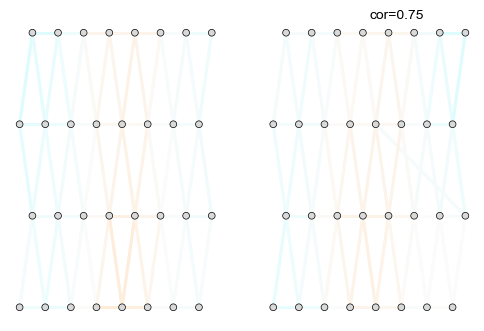

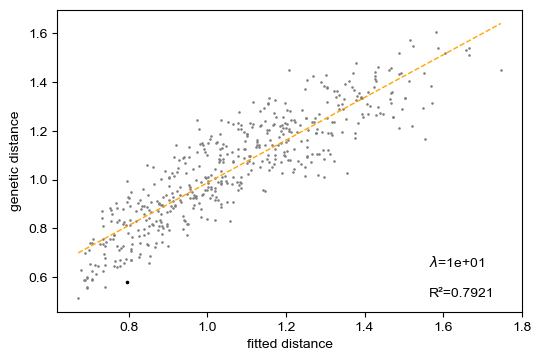

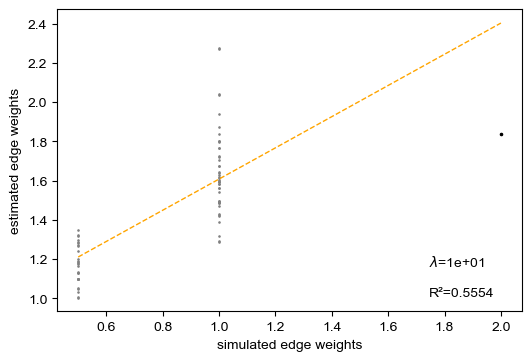

In [651]:
# obtaining pairs of nodes with maximum residuals (TOP 1)
max_res_nodes = comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=1, lamb=10.0, plotFig=False)

# creating a new spatial graph with extra edge
gr = deepcopy(graph_def)
gr.add_edges_from(max_res_nodes)
sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(gr.edges)+1)

# visualtization of feems fit
plot_default_vs_long_range(sp_Graph_def, sp_Graph, max_res_nodes, lamb=10.0)

comp_genetic_vs_fitted_distance(sp_Graph, lrn, lamb=10.0, plotFig=True)

plot_estimated_vs_simulated_edges(graph, sp_Graph, lrn, max_res_nodes, lamb=10.0)

## Default `feems` fit  

In [ ]:
# %%time
# sp_Graph.fit_null_model()
# sp_Graph.fit(lamb = 10.0)

Surprisingly, it seems like the long range migration edge (0,12) is captured by the model! However, this could be because I set the long range migraton to be 4x more than corridor and 20x more than barrier migration rate. Below I use a root mean squared relative error to calculate deviation of estimated from simulated but weighted with respect to the estimated value
$$
\text{RMSRE} = \sqrt{1/n \sum_i \Big(\frac{X_i - T_i}{T_i}\Big)^2}
$$

In [ ]:
def rmsre_edge_weights(graph, sp_Graph):
    # simulated graph edges
    sim_edges = np.array([graph[val[0]][val[1]]["w"] for _, val in enumerate(list(graph.edges))])
    return np.sqrt(np.mean(((sp_Graph.w-sim_edges)/sp_Graph.w)**2))

### Further testing with varying parameters 

Now, I will try out the following parameter regimes: more disconnected long range edges, weaker long range migration, and multiple incoming long range edges to same node. The previous parameter regime had one long range edge between node 0 and 12 with migration rate of 1.0 (compared to 0.5 in the corridors and 0.1 in the barrier). 

#### 1. Varying number of long range edges

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 150
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 300
Simulating ~SNP 350
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 900
Simulating ~SNP 950


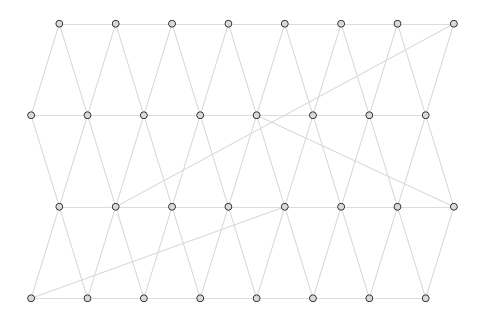

In [529]:
lrn = [(0,12),(15,20),(9,31)]
graph, coord, grid, edge = setup_graph_long_range(corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[1.0,1.0,1.0])
gen_test = simulate_genotypes(graph)

proj_test = ccrs.EquidistantConic(central_longitude=5.5, central_latitude=3.0)
# drawing the simulated graph 
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

constant-w/variance fit, converged in 130 iterations, train_loss=3632.0027258
lambda=10.0000000, alpha=0.6431790, converged in 14 iterations, train_loss=3465.8404878
constant-w/variance fit, converged in 130 iterations, train_loss=3632.0027258
lambda=10.0000000, alpha=0.6431790, converged in 12 iterations, train_loss=3465.8404912
constant-w/variance fit, converged in 134 iterations, train_loss=14041.9191622
lambda=10.0000000, alpha=1.2730078, converged in 12 iterations, train_loss=13321.0124905
constant-w/variance fit, converged in 134 iterations, train_loss=14041.9191622
lambda=10.0000000, alpha=1.2730078, converged in 12 iterations, train_loss=13321.0124899


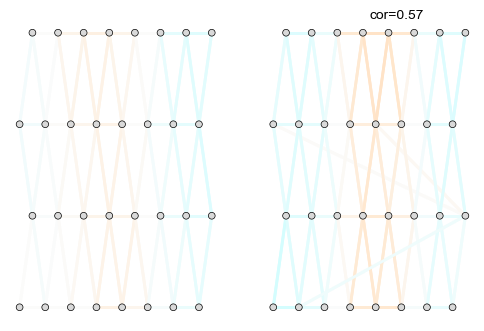

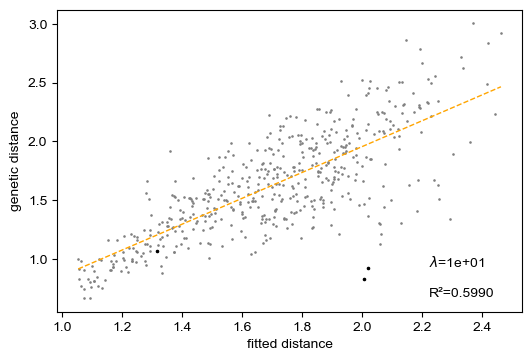

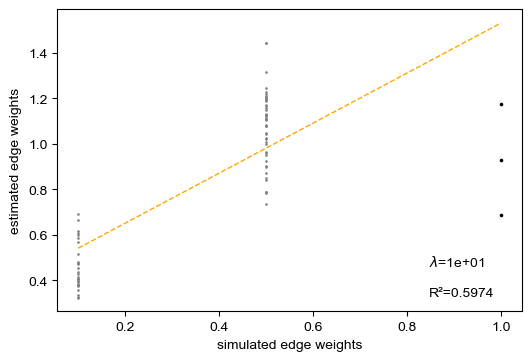

In [577]:
# obtaining pairs of nodes with maximum residuals (TOP 3)
max_res_nodes = comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=3, lamb=10.0, plotFig=False)

# creating a new spatial graph with extra edge
gr = deepcopy(graph_def)
gr.add_edges_from(max_res_nodes)
sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(gr.edges)+1)

# visualtization of feems fit
plot_default_vs_long_range(sp_Graph_def, sp_Graph, max_res_nodes, lamb=10.0)

comp_genetic_vs_fitted_distance(sp_Graph, lrn, lamb=10.0, plotFig=True)

plot_estimated_vs_simulated_edges(graph, sp_Graph, lrn, max_res_nodes, lamb=10.0)

The above result shows that `feems` does pretty well in finding multiple long range migration edges, even with somewhat similar migration rates to the corridors (2x, compared to 4x from before). 

#### 2. Weak migration (similar to corridor rates)

Based on the results from the analysis below, I still find that `feems` does well in capturing these long range migrations. 
<a id='weakmigration'></a>

Simulating ~SNP 0
Simulating ~SNP 100
Simulating ~SNP 150
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 300
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 950


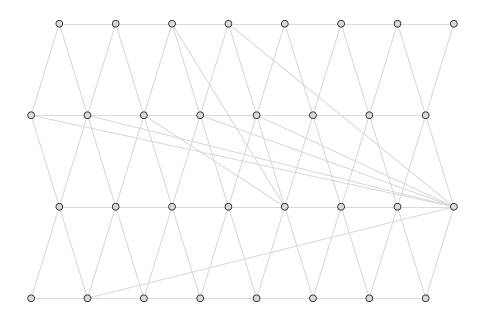

In [621]:
graph, coord, grid, edge = setup_graph_long_range(corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[0.5,0.5,0.5])
gen_test = simulate_genotypes(graph)

proj_test = ccrs.EquidistantConic(central_longitude=5.5, central_latitude=3.0)
# drawing the simulated graph 
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

In [625]:
# obtaining pairs of nodes with maximum residuals (TOP 3)
max_res_nodes = comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=5, lamb=10.0, plotFig=False)

# creating a new spatial graph with extra edges
gr = deepcopy(graph_def)
gr.add_edges_from(max_res_nodes)
sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(gr.edges)+1)

# visualtization of feems fit
plot_default_vs_long_range(sp_Graph_def, sp_Graph, max_res_nodes, lamb=10.0)

comp_genetic_vs_fitted_distance(sp_Graph, lrn, lamb=10.0, plotFig=True)

plot_estimated_vs_simulated_edges(graph, sp_Graph, lrn, max_res_nodes, lamb=10.0)

constant-w/variance fit, converged in 130 iterations, train_loss=3632.0027258
lambda=10.0000000, alpha=0.6431790, converged in 14 iterations, train_loss=3465.8404878
constant-w/variance fit, converged in 130 iterations, train_loss=3632.0027258
lambda=10.0000000, alpha=0.6431790, converged in 12 iterations, train_loss=3465.8404912
constant-w/variance fit, converged in 136 iterations, train_loss=14768.0138060
lambda=10.0000000, alpha=1.3718321, converged in 14 iterations, train_loss=13816.0558457


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 78 and the array at index 1 has size 73

#### 3. Multiple long range migration edges to same node

Based on the results below, `feems` works well to estimate these long range migration edges accurately, even with multiple edges to the same node. 

In [624]:
lrn = [(0,12),(12,31),(12,24)]
graph, coord, grid, edge = setup_graph_long_range(corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[1.0,1.0,1.0])
gen_test = simulate_genotypes(graph)

proj_test = ccrs.EquidistantConic(central_longitude=5.5, central_latitude=3.0)
# drawing the simulated graph 
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

Simulating ~SNP 0
Simulating ~SNP 100
Simulating ~SNP 250
Simulating ~SNP 350
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 900
Simulating ~SNP 950


AttributeError: 'Graph' object has no attribute 'node_pos'

In [626]:
# obtaining pairs of nodes with maximum residuals (TOP 3)
max_res_nodes = comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=5, lamb=10.0, plotFig=False)

# creating a new spatial graph with extra edges
graph_def.add_edges_from(max_res_nodes)
sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(graph_def.edges)+1)

# visualtization of feems fit
plot_default_vs_long_range(sp_Graph_def, sp_Graph, max_res_nodes, lamb=10.0)

comp_genetic_vs_fitted_distance(sp_Graph, lrn, lamb=10.0, plotFig=True)

plot_estimated_vs_simulated_edges(graph, sp_Graph, lrn, max_res_nodes, lamb=10.0)

constant-w/variance fit, converged in 130 iterations, train_loss=3632.0027258
lambda=10.0000000, alpha=0.6431790, converged in 14 iterations, train_loss=3465.8404878
constant-w/variance fit, converged in 130 iterations, train_loss=3632.0027258
lambda=10.0000000, alpha=0.6431790, converged in 12 iterations, train_loss=3465.8404912
constant-w/variance fit, converged in 136 iterations, train_loss=14768.0138060
lambda=10.0000000, alpha=1.3718321, converged in 14 iterations, train_loss=13816.0558457


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 78 and the array at index 1 has size 73

### Spoofing the model by giving it all possible edges

Here, I will simulate under the model in **3** (multiple long range edges to same node) above, but will provide the model with edges connecting every population to every other population as a way of seeing if the model can detect the edges with long range migration. 

In [ ]:
# constructing the graph object
## every combination of edge with same genotypes as before
sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(list(it.combinations(np.arange(1,33),2))))

proj_test = ccrs.EquidistantConic(central_longitude=5.5, central_latitude=3.0)
# drawing the simulated graph 
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

## Main takeaways

1. For long range migration that is larger than corridor, I find that the estimated migration rates are always lower than the simulated (same for fitted distance when compared to genetic distance). 
2. For long range migration that is similar to corridor, I find that on average the estimated and simulated migration rates are the same (though there is variance within the estimates, see [Section 2](#weakmigration))

## Investigating the 'greedy' approach to fitting long range edges

First, I will see if the covariance of allele frequencies across nodes tells us something about which nodes could potentially have a long range migration. This seems promising, in that for node 0 is found to covary with node 12 the third-most (right after its neighboring nodes). 

In [ ]:
np.set_printoptions(threshold=np.inf)
np.argsort(sp_Graph.S[16,:],)
np.argsort(sp_Graph_def.S[22,:]-np.max(sp_Graph_def.S[22,:]))

In [ ]:
sp_Graph_def.Delta.toarray()[32,:]

In [ ]:
max_idx=np.where(np.abs((res.resid-np.mean(res.resid))/np.std(res.resid))>3)[0]

In [ ]:
max_idx[0]

In [ ]:
max_res_node = []
for k in max_idx:
    x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1
    y = np.int(k - 0.5*x*(x-1))
    max_res_node.append((x,y))

In [ ]:
sp_Graph_def.edges